# 📚 AI를 활용한 생공용수 수요패턴 예측

## 1. 필요한 라이브러리 입력

In [1]:
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import shap
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from bayes_opt import BayesianOptimization
from prophet import Prophet
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
import os

from metrics import evaluate
from plots import bar_metrics

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")

# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family="NanumGothic")
print(tf.__version__)

2022-10-14 07:59:35.338460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 07:59:36.396871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 07:59:36.396934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-14 07:59:36.530887: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 07:59:38.980054: W tensorflow/stream_executor/platform/de

2.10.0


The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.


## 2. 데이터 불러오기 (예시: 서울특별시)

### 2.1 과거 영향인자 데이터 불러오기

 * 2001~2021년 월별 인구관련 영향인자 7개 ("총인구수", '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율')
               월별 기상관련 영향인자 3개 ("기온", "월강수량", "습도") 엑셀에서 불러오기

In [2]:
os.listdir('../data/영향분석/시군별_영향인자(독립변수)')

['경상북도',
 '강원도',
 '시군구코드.xlsx',
 '제주도',
 '경상남도',
 '경기도',
 '전라북도',
 '충청북도',
 '특광역시',
 '충청남도',
 '전라남도',
 '~$시군구코드.xlsx']

In [3]:
os.listdir('../data/영향분석/시군별_영향인자(독립변수)/특광역시')

['특별시 및 광역시 종합.xlsx']

In [4]:
factor_1 = pd.ExcelFile("../data/영향분석/시군별_영향인자(독립변수)/특광역시/특별시 및 광역시 종합.xlsx")
factor_1.sheet_names

['서울특별시', '세종특별자치시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시']

In [5]:
# 시군명 지정
CITY_NAME = '서울특별시'

In [6]:
factor_1 = pd.read_excel("../data/영향분석/시군별_영향인자(독립변수)/특광역시/특별시 및 광역시 종합.xlsx", sheet_name=CITY_NAME) # 시군별 영향인자 엑셀파일 읽기
factor_1_1 = factor_1.iloc[3:, :29] # header 및 일단위자료 삭제
factor_1_1.columns = factor_1.iloc[2, :29] # set column names
data_len = factor_1_1['연도'].isna().argmax()
factor_1_1 = factor_1_1[:data_len]
factor_1_1.index = pd.to_datetime(factor_1_1['연도'][:data_len].astype(str) + '-' + factor_1_1['월'][:data_len].astype(str))
factor_1_1.rename_axis(columns='', inplace=True)
factor_1_1.drop(columns=['연도', '월'], inplace=True)
# Simplify Column names
factor_1_1.columns = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', '전력사용량', '산업체 수', '100인 이상 사업장', 
                       '산업단지면적', '연간 가계소득', '연간 고등학교 졸업(명)', '연간 고등학교 졸업자 비율', '연간 인건비', '연간 평균 수입대비 인건비', '취업률(명)', 
                       '고용보험자 비율', '취약계층(개)', '취약계층(비율)', '기온', '월강수량', '습도', '일조량', '지중온도', '풍량', '기압']
# Change datatype from object to float
factor_1_1 = factor_1_1.astype(float)
# 해당 컬럼만 불러오기
factors = factor_1_1[["총인구수", '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율', "기온", "월강수량", "습도"]]
factors = factors.astype(float)
factors.index.name = "date"
factors

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.1,39.4,62.0
2001-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.3,45.7,60.0
2001-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,18.1,51.0
2001-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.6,12.3,50.0
2001-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.1,16.5,61.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,9550227.0,4416816.0,2.162242,4640740.0,4909487.0,0.945260,16.5,25.9,211.2,74.0
2021-09-01,9542256.0,4421143.0,2.158323,4636069.0,4906187.0,0.944943,16.6,22.6,131.0,71.0
2021-10-01,9532428.0,4422587.0,2.155396,4630630.0,4901798.0,0.944680,16.7,15.6,57.0,70.0


### 2.2 과거 종속변수 데이터 (용수공급량) 불러오기

 * 2001~2021년 월별 용수공급량 데이터 엑셀에서 불러오기

In [7]:
water_supply = pd.read_excel("../data/영향분석/가뭄DB 시군별 일평균 공급량(17-21).xlsx", header=1)
water_supply.set_index("지자체명", inplace=True)
water_supply = water_supply.iloc[1:, 1:]
water_supply = water_supply[[CITY_NAME]]
water_supply.rename(columns = {CITY_NAME:f'{CITY_NAME}'}, inplace = True)
water_supply = water_supply.astype(float)
water_supply.index = pd.to_datetime(water_supply.index.astype(str))
water_supply.index.name = "date"
water_supply

,서울특별시
date,
2017-01-01,3.007799e+06
2017-02-01,3.029100e+06
2017-03-01,3.064747e+06
2017-04-01,3.117700e+06
2017-05-01,3.189195e+06
2017-06-01,3.293463e+06
2017-07-01,3.329908e+06
2017-08-01,3.270567e+06
2017-09-01,3.223462e+06


### 2.3 미래 영향인자 불러오기

 * 2022~2037년 년별 "총인구수", '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율' 자료

In [8]:
future_factor = pd.read_excel("../data/수요예측/시군별_영향인자_장래예측/특광역시.xlsx", sheet_name=CITY_NAME)
future_factor_1 = future_factor.iloc[3:19, :8] # header 및 일단위자료 삭제
future_factor_1.columns = future_factor.iloc[2, :8] # set column names
future_factor_1.index = pd.to_datetime(future_factor_1["연도"], format='%Y')
future_factor_1 = future_factor_1.resample('MS').ffill()
future_factor_1.index.name = "date"
future_factors1 = future_factor_1[future_factor_1.columns[1:]]
future_factors1.columns = ['총인구수', '세대수', '세대당 인구', '남자 인구수', '여자 인구수', '남여 비율', '고령화비율']
future_factors1 = future_factors1.astype(float)
future_factors1

,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율
date,,,,,,,
2022-01-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-02-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-03-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-04-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
2022-05-01,9487764.0,3873473.0,2.449420,4591453.0,4896311.0,0.937737,0.170804
...,...,...,...,...,...,...,...
2036-09-01,8912133.0,3872077.0,2.301641,4268533.0,4643600.0,0.919229,0.292904
2036-10-01,8912133.0,3872077.0,2.301641,4268533.0,4643600.0,0.919229,0.292904
2036-11-01,8912133.0,3872077.0,2.301641,4268533.0,4643600.0,0.919229,0.292904


### 2.4 미래 기후 영향인자 불러오기

 * 2022~2040년 년별 "월강수량", "습도", "최고온도", "최저온도", "평균온도"

In [9]:
future_factor_3 = future_factor.iloc[3:, 22:28] # header 및 일단위자료 삭제
future_factor_3.columns = future_factor.iloc[2, 22:28] # set column names
future_factor_3.index = pd.to_datetime(future_factor_3["날짜"], format='%Y%M%D')
future_factor_3.index.name = "date"
future_factors2 = future_factor_3[['월합강수량(mm)', '습도\n평균상대습도(%)', '평균온도(°C)']]
future_factors2.columns = ['월강수량', '습도', '기온']
future_factors2 = future_factors2.astype(float)
future_factors2

,월강수량,습도,기온
date,,,
2011-01-01,0.324555,0.534812,0.948139
2011-02-01,34.764428,0.634345,5.835217
2011-03-01,84.897622,0.588337,6.949007
2011-04-01,91.282635,0.603537,12.935536
2011-05-01,34.863007,0.599980,18.248352
...,...,...,...
2040-08-01,287.641623,0.795657,28.848732
2040-09-01,205.844536,0.748112,23.742447
2040-10-01,8.553179,0.609581,17.723693


### 2.5 용수수요 추정을 위한 과거 및 미래자료 합치기


In [10]:
total_data = pd.merge(water_supply, factors, on="date", how="left")
future_factors1_1 = future_factors1.loc["2022-01-01":"2035-01-01"]
future_factors2_1 = future_factors2.loc["2022-01-01":"2035-01-01"]
future_factor = pd.concat([future_factors1_1, future_factors2_1], axis=1)
total_data_df = pd.concat([total_data, future_factor], axis=0)
total_data_df

,서울특별시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
2017-01-01,3.007799e+06,9930478.0,4192985.0,2.368355,4875745.0,5054733.0,0.964590,13.100000,-1.800000,14.900000,55.000000
2017-02-01,3.029100e+06,9931412.0,4200761.0,2.364194,4874839.0,5056573.0,0.964060,13.200000,-0.200000,11.100000,54.000000
2017-03-01,3.064747e+06,9926968.0,4202888.0,2.361940,4871560.0,5055408.0,0.963633,13.300000,6.300000,7.900000,48.000000
2017-04-01,3.117700e+06,9922745.0,4203957.0,2.360335,4868367.0,5054378.0,0.963198,13.300000,13.900000,61.600000,52.000000
2017-05-01,3.189195e+06,9919016.0,4207393.0,2.357521,4865778.0,5053238.0,0.962903,13.400000,19.500000,16.100000,52.000000
...,...,...,...,...,...,...,...,...,...,...,...
2034-09-01,NaN,8994658.0,3888453.0,2.313171,4314660.0,4679998.0,0.921936,0.274925,23.841022,17.473418,0.639263
2034-10-01,NaN,8994658.0,3888453.0,2.313171,4314660.0,4679998.0,0.921936,0.274925,16.753755,21.209567,0.560021
2034-11-01,NaN,8994658.0,3888453.0,2.313171,4314660.0,4679998.0,0.921936,0.274925,11.048479,19.714946,0.561118


### 2.6 이용가능한 데이터 기간 검토


 - 물공급량: 1991-01월 ~ 2021-12월
 - 지역성 영향인자: 2008-01월 ~ 2034-12월
 - 계절성 영향인자: 2001-01월 ~ 2034-12월  

<div class="alert alert-block alert-info">
    
<b> 지역성 영향인자와 계절성 영향인자의 이용가능한 데이터 기간을 고려한 용수수요 AI모델개발을 위한 데이터 현황
    
<b>   - 데이터 이용가능 기간: 2008-01월~2021년12월 (총 168개 데이터, 14년) <b>
    
<b>   - Training       기간: 2008-01월~2018년12월 (총 132개 데이터, 11년)  <b>
    
<b>   - Testing        기간: 2019-01월~2021년12월 (총  36개 데이터,  3년) </b> </div>

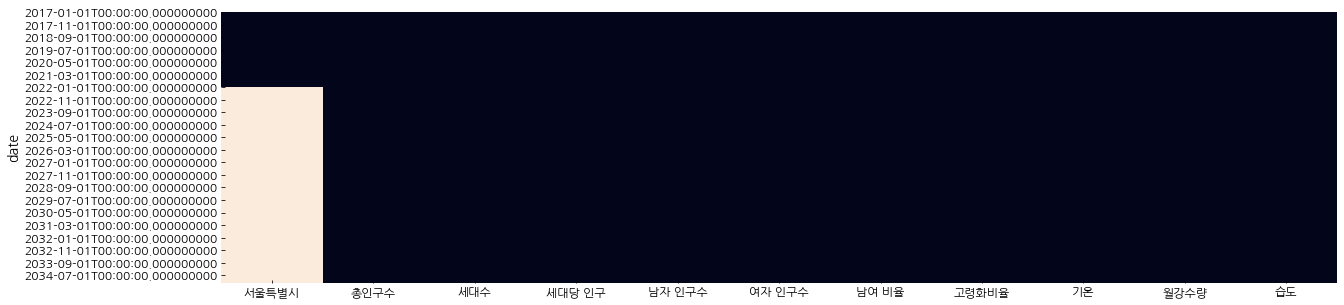

In [11]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(total_data_df.isnull(), cbar=False)
plt.show()

## 3. 시계열 자료 분석

### 3.1 시계열자료 불러오기 및 Review


In [12]:
total_data_df_ts_analysis = total_data_df.loc["2017-01-01":"2021-12-01"]
total_data_df_ts_analysis

,서울특별시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
2017-01-01,3.007799e+06,9930478.0,4192985.0,2.368355,4875745.0,5054733.0,0.964590,13.1,-1.8,14.9,55.0
2017-02-01,3.029100e+06,9931412.0,4200761.0,2.364194,4874839.0,5056573.0,0.964060,13.2,-0.2,11.1,54.0
2017-03-01,3.064747e+06,9926968.0,4202888.0,2.361940,4871560.0,5055408.0,0.963633,13.3,6.3,7.9,48.0
2017-04-01,3.117700e+06,9922745.0,4203957.0,2.360335,4868367.0,5054378.0,0.963198,13.3,13.9,61.6,52.0
2017-05-01,3.189195e+06,9919016.0,4207393.0,2.357521,4865778.0,5053238.0,0.962903,13.4,19.5,16.1,52.0
2017-06-01,3.293463e+06,9914381.0,4210933.0,2.354438,4862573.0,5051808.0,0.962541,13.5,23.3,66.6,57.0
2017-07-01,3.329908e+06,9908612.0,4213667.0,2.351541,4859039.0,5049573.0,0.962267,13.5,26.9,621.0,77.0
2017-08-01,3.270567e+06,9902072.0,4217954.0,2.347601,4855013.0,5047059.0,0.961949,13.6,25.9,297.0,71.0
2017-09-01,3.223462e+06,9891448.0,4219001.0,2.344500,4849195.0,5042253.0,0.961712,13.6,22.1,35.0,61.0


In [13]:
total_data_df_ts_analysis.describe().applymap('{:,.2f}'.format)

,서울특별시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
count,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00,60.00
mean,"3,200,941.35","9,749,907.07","4,311,657.48",2.26,"4,759,545.58","4,990,361.48",0.95,14.94,13.28,104.10,60.23
std,"120,236.93","115,153.81","80,240.69",0.07,"71,881.84","43,692.99",0.01,1.10,10.08,126.06,9.04
min,"2,959,960.42","9,509,458.00","4,192,985.00",2.15,"4,618,040.00","4,891,418.00",0.94,13.10,-4.00,0.00,45.00
25%,"3,129,663.62","9,696,713.75","4,239,288.50",2.20,"4,717,806.50","4,978,907.25",0.95,14.00,4.88,23.50,54.00
50%,"3,183,980.05","9,754,279.50","4,306,271.50",2.27,"4,760,908.00","4,992,069.50",0.95,14.85,14.05,62.00,59.00
75%,"3,266,707.79","9,832,562.00","4,401,118.00",2.32,"4,813,762.25","5,018,799.75",0.96,15.93,22.60,139.65,68.00
max,"3,491,067.06","9,931,412.00","4,427,814.00",2.37,"4,875,745.00","5,056,573.00",0.96,16.80,28.80,675.70,85.00


Lets check each feature values

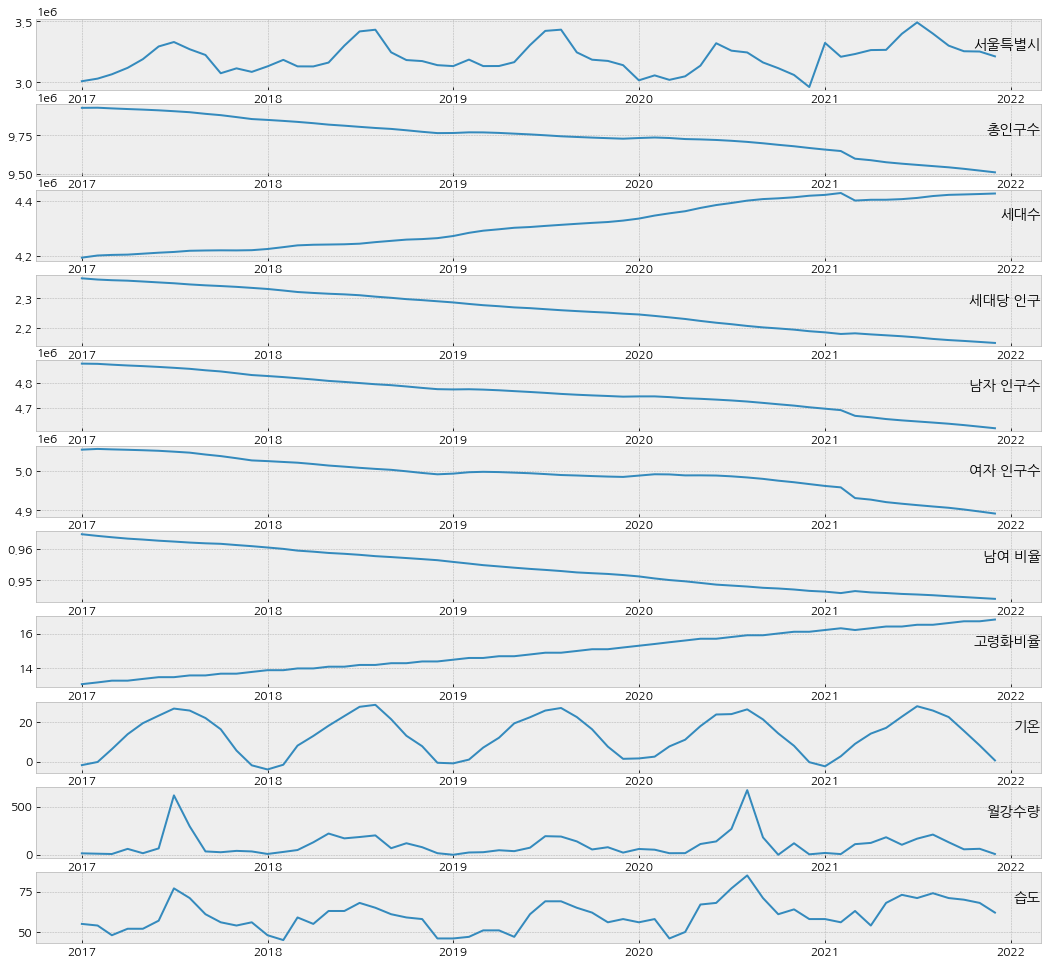

In [14]:
rcParams['figure.figsize'] = 18, 17
values = total_data_df_ts_analysis.values
groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(total_data_df_ts_analysis.index,  values[:, group])
    plt.title(total_data_df_ts_analysis.columns[group], y=0.5, loc='right')
    i += 1

plt.show()

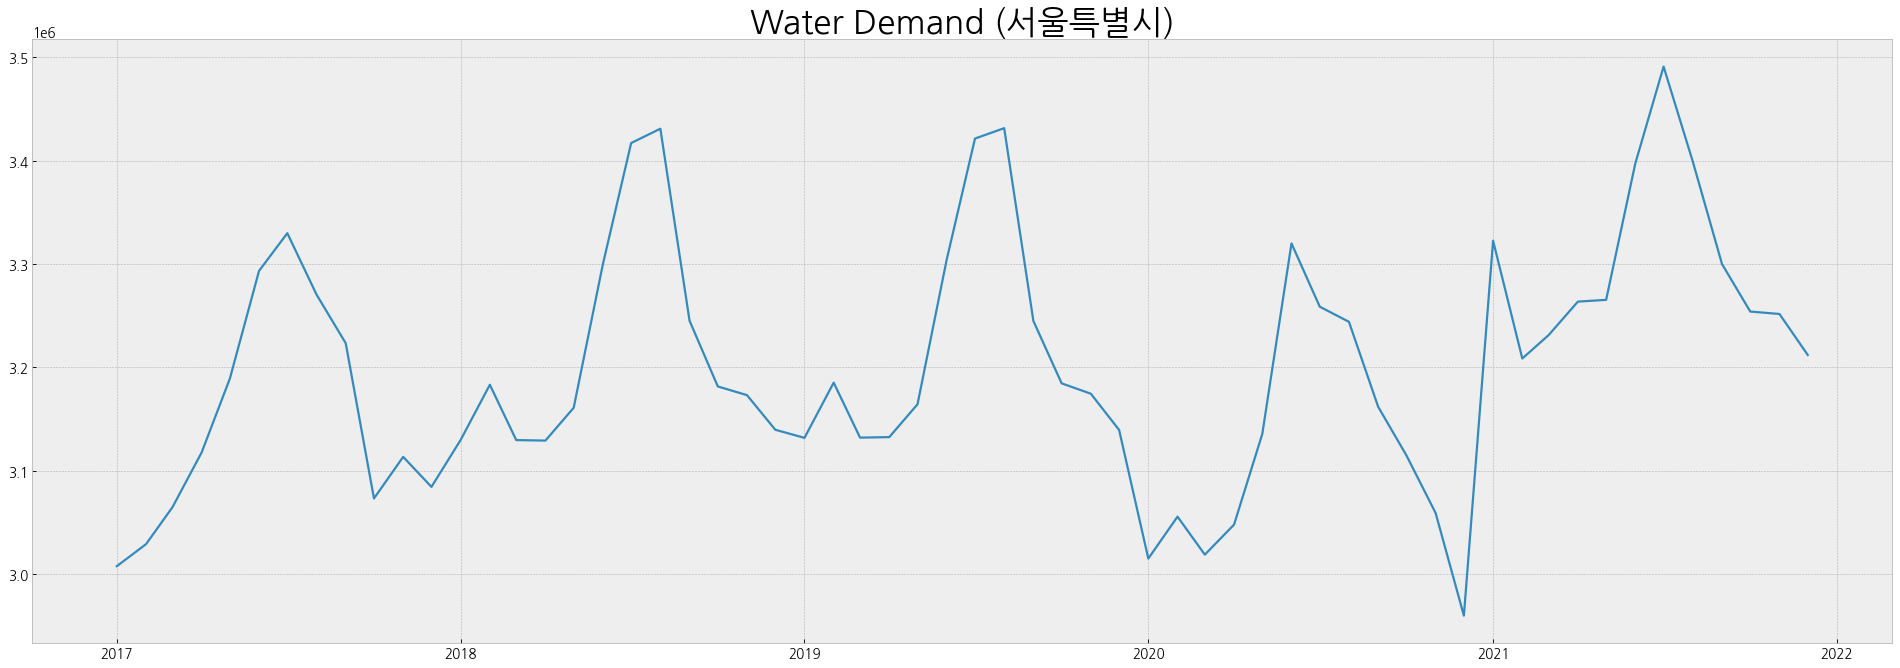

In [15]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Water Demand (%s)'%CITY_NAME, fontsize=30)

plt.plot(total_data_df_ts_analysis[CITY_NAME])
os.makedirs("results", exist_ok=True)
plt.savefig("results/water_demand.png")

### 3.2 시계열자료 분해


시계열 자료를 추세(Trend), 계절성(Seasonality)와 잔여분(Resid, Residual)을 활용하여 시계열 자료 특성 분석

##### Additive Model (덧셈모델)
`y(t) = Value + Trend + Seasonality + Noise`

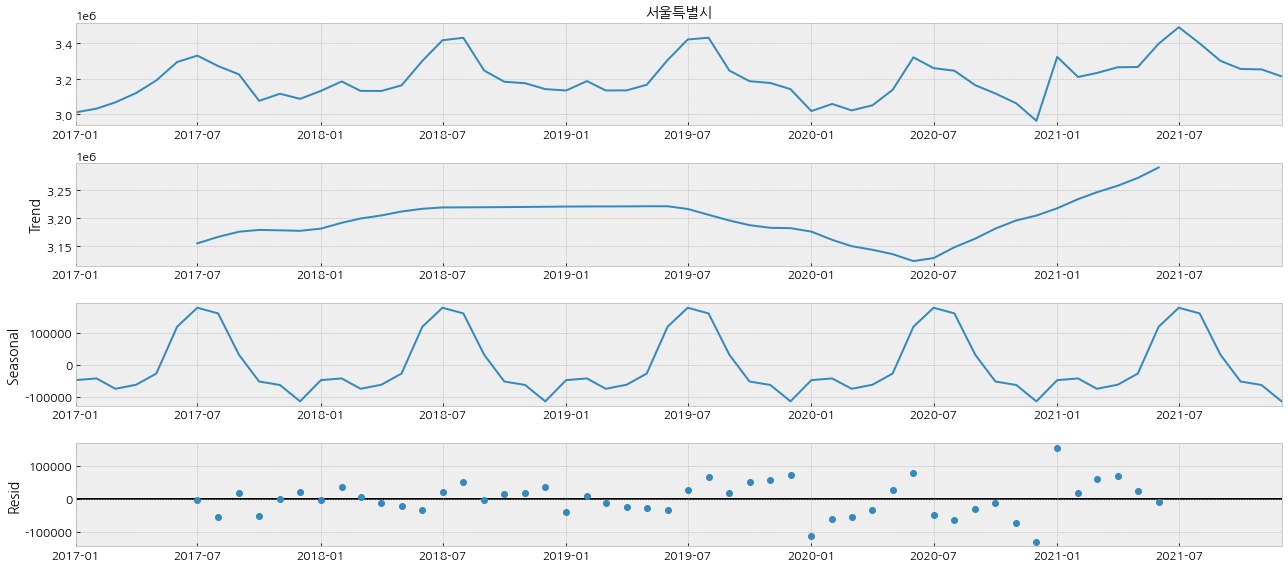

<Figure size 4000x1600 with 0 Axes>

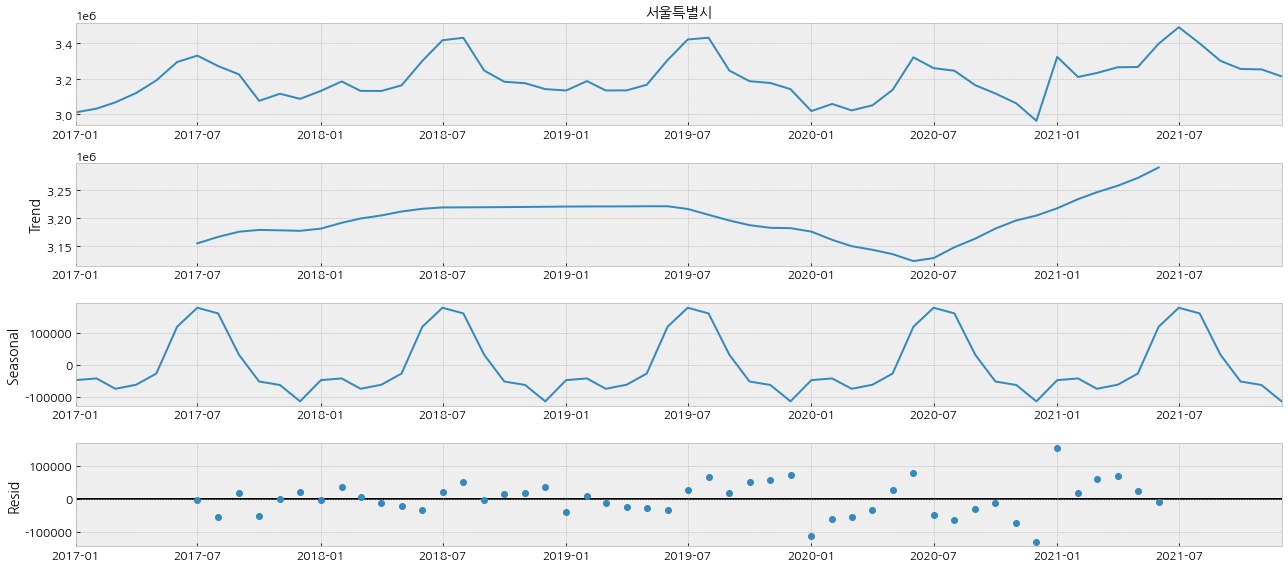

In [16]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = total_data_df_ts_analysis[CITY_NAME]
result = seasonal_decompose(series, model='additive')
result.plot()

##### Multiplicative model (곱셈모델)
`y(t) = Level * Trend * Seasonality * Noise`

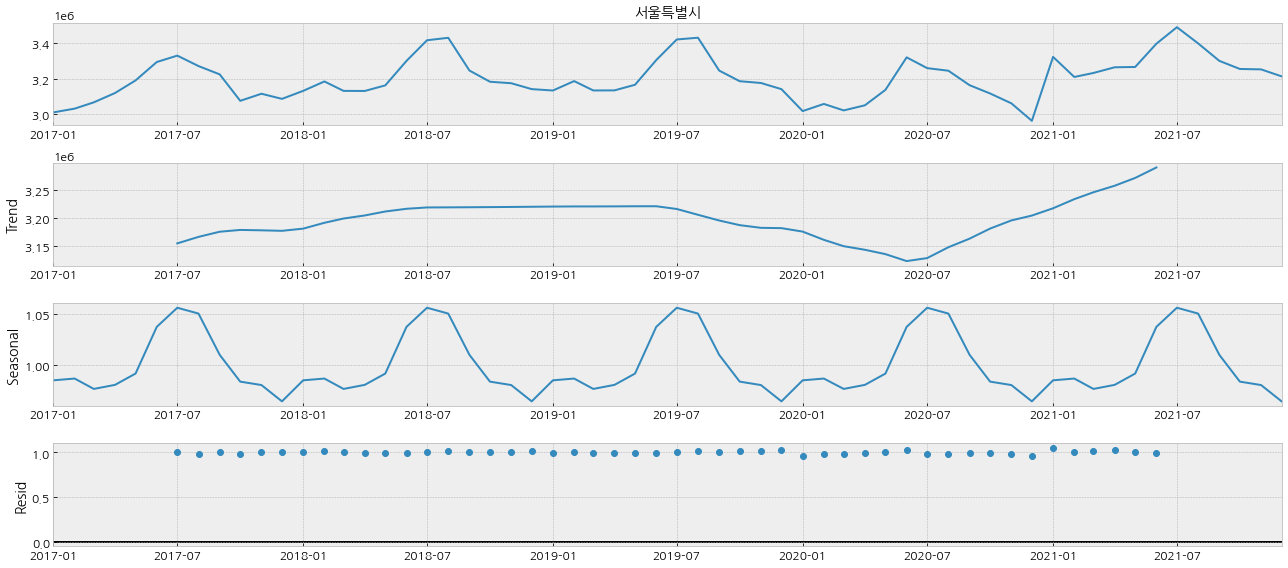

<Figure size 4000x1600 with 0 Axes>

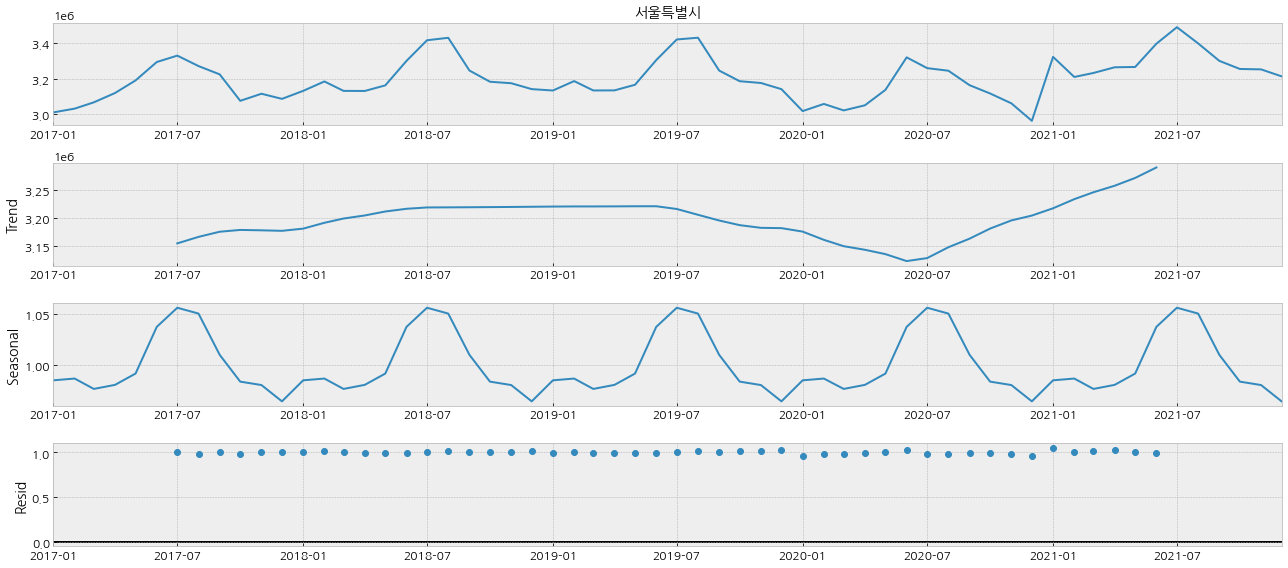

In [17]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = total_data_df_ts_analysis[CITY_NAME]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

### 3.3 시계열 데이터의 정상성 확인

#### AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF) plots

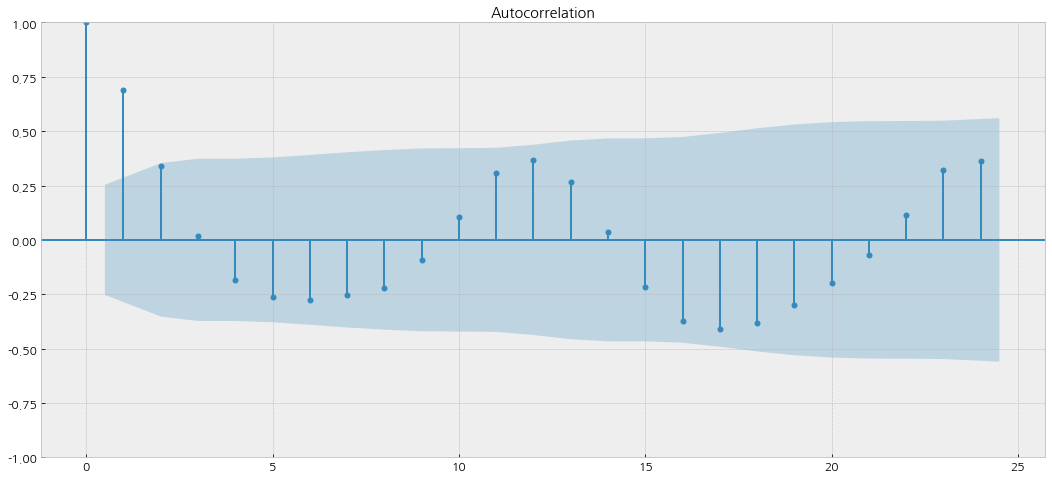

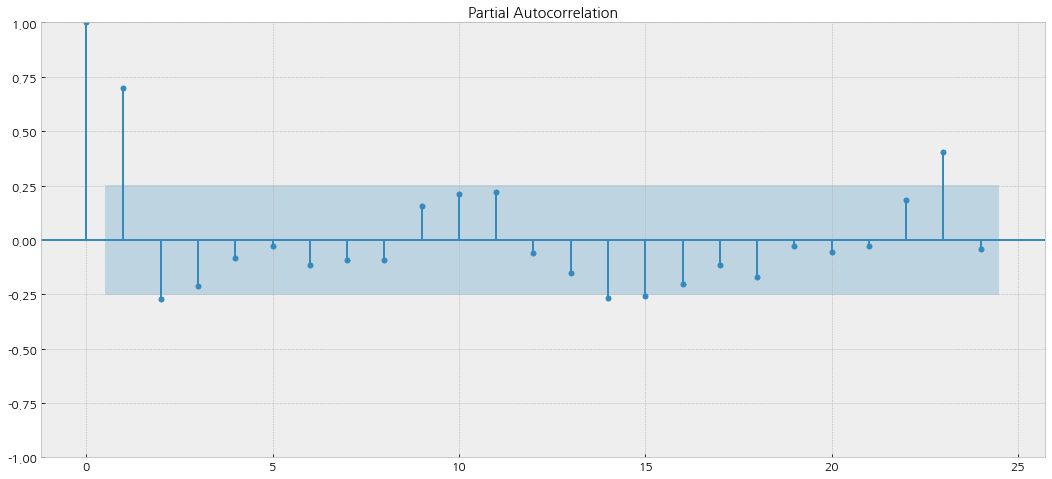

In [18]:
plot_acf(series, lags=24)
plot_pacf(series, lags=24)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

### Augmented Dickey-Fuller test


In [19]:
X = total_data_df_ts_analysis[CITY_NAME].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.970273
p-value: 0.001574
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


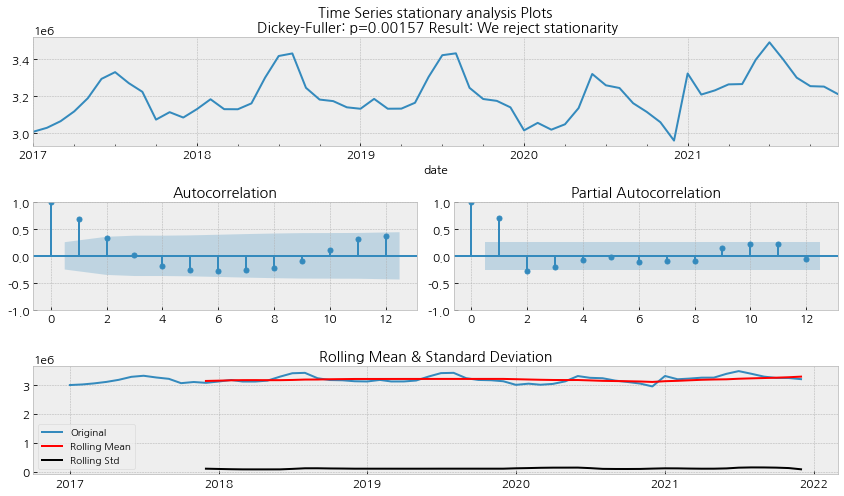

In [20]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = total_data_df_ts_analysis[CITY_NAME].rolling(window=12).mean()
        rolstd = total_data_df_ts_analysis[CITY_NAME].rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(total_data_df_ts_analysis[CITY_NAME], label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(total_data_df_ts_analysis[CITY_NAME], lags=12)

## 4. 용수수요 추정

### 4.1 데이터 준비

In [21]:
total_data_df_ts_analysis = total_data_df.loc["2017-01-01":"2021-12-01"]
total_data_df_ts_analysis.head()

,서울특별시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
2017-01-01,3.007799e+06,9930478.0,4192985.0,2.368355,4875745.0,5054733.0,0.964590,13.1,-1.8,14.9,55.0
2017-02-01,3.029100e+06,9931412.0,4200761.0,2.364194,4874839.0,5056573.0,0.964060,13.2,-0.2,11.1,54.0
2017-03-01,3.064747e+06,9926968.0,4202888.0,2.361940,4871560.0,5055408.0,0.963633,13.3,6.3,7.9,48.0
2017-04-01,3.117700e+06,9922745.0,4203957.0,2.360335,4868367.0,5054378.0,0.963198,13.3,13.9,61.6,52.0
2017-05-01,3.189195e+06,9919016.0,4207393.0,2.357521,4865778.0,5053238.0,0.962903,13.4,19.5,16.1,52.0


#### Training과 Testing 데이터의 구분

In [22]:
# We split our dataset to be able to evaluate our models
resultsDict = {}
predictionsDict = {}

split_date = '2020-12-01'
df_training = total_data_df_ts_analysis.loc[total_data_df_ts_analysis.index <= split_date]
df_test = total_data_df_ts_analysis.loc[total_data_df_ts_analysis.index > split_date]
print(f"{len(df_training)} months of training data \n {len(df_test)} months of testing data ")

48 months of training data 
 12 months of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

### 4.1 Random Forest

In [23]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [24]:
X_train_df, y_train = create_time_features(
    df_training, target=CITY_NAME)
X_test_df, y_test = create_time_features(df_test, target=CITY_NAME)
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [25]:
reg = RandomForestRegressor(random_state=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test[CITY_NAME], yhat)
predictionsDict['Randomforest'] = yhat

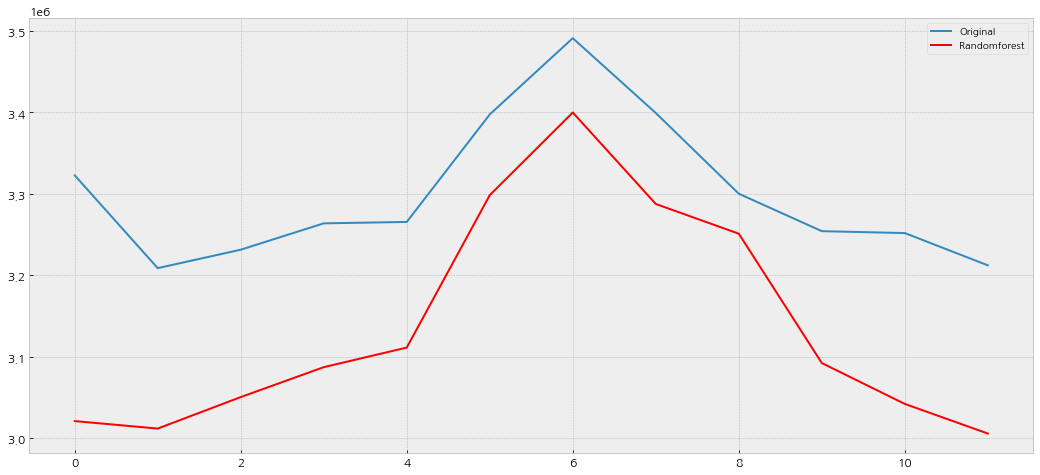

In [26]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='Randomforest')
plt.legend()

In [27]:
resultsDict

{'Randomforest': {'mae': 161667.80997866264,
  'rmse': 174049.61361410082,
  'mape': 0.04926643657162172,
  'r2': -3.3239051020151953}}

In [28]:
X_predict_df, y_predict = create_time_features(
    total_data_df.loc["2022-01-01":], target=CITY_NAME)
scaler = StandardScaler()
scaler.fit(X_predict_df)  # No cheating, never scale on the training+test!
X_predit = scaler.transform(X_predict_df)

water_predict = reg.predict(X_predit)

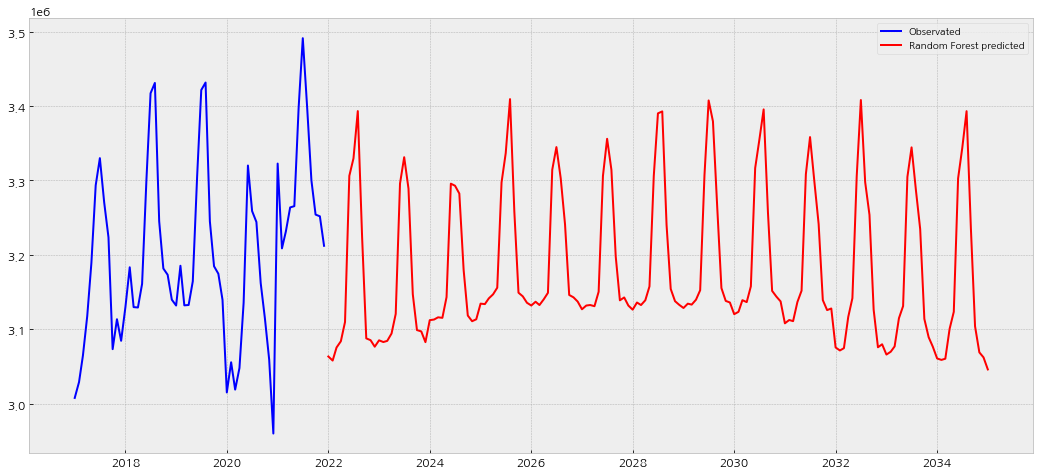

In [29]:
total_data_df[CITY_NAME].loc["2022-01-01":] = water_predict
plt.plot(total_data_df[CITY_NAME].loc[:"2021-12-01"], color='blue', label='Observated')
plt.plot(total_data_df[CITY_NAME].loc["2022-01-01":], color='red', label='Random Forest predicted')
plt.legend()

### 4.2 XGBoost

In [30]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test[CITY_NAME], yhat)
predictionsDict['XGBoost'] = yhat

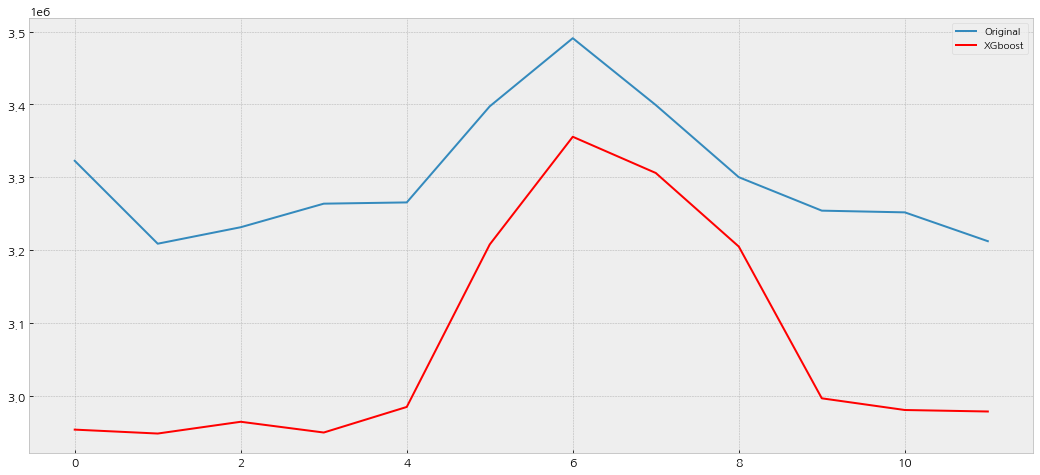

In [31]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='XGboost')
plt.legend()

In [32]:
resultsDict

{'Randomforest': {'mae': 161667.80997866264,
  'rmse': 174049.61361410082,
  'mape': 0.04926643657162172,
  'r2': -3.3239051020151953},
 'XGBoost': {'mae': 230847.10549155145,
  'rmse': 245095.27352586162,
  'mape': 0.07034601528040747,
  'r2': -7.574324180173743}}

In [33]:
X_predict_df, y_predict = create_time_features(
    total_data_df.loc["2022-01-01":], target=CITY_NAME)
scaler = StandardScaler()
scaler.fit(X_predict_df)  # No cheating, never scale on the training+test!
X_predit = scaler.transform(X_predict_df)

water_predict = reg.predict(X_predit)

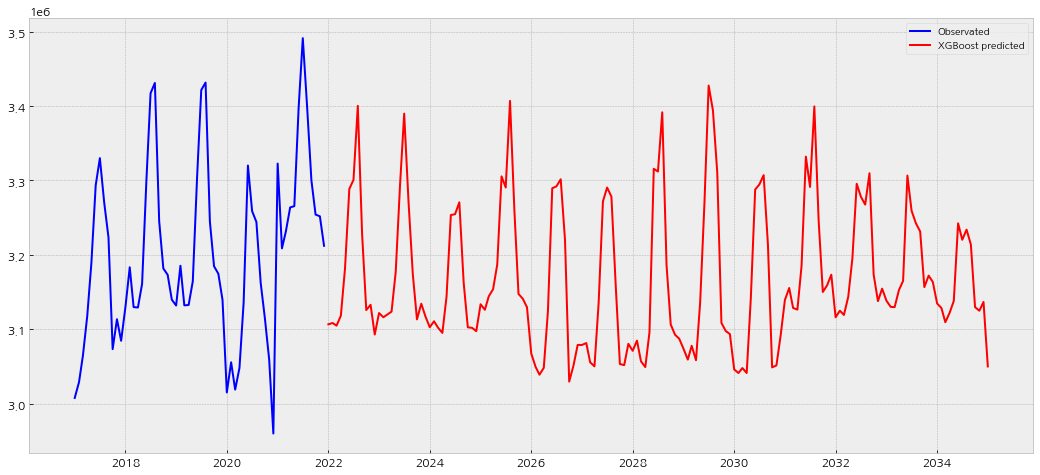

In [34]:
total_data_df[CITY_NAME].loc["2022-01-01":] = water_predict
plt.plot(total_data_df[CITY_NAME].loc[:"2021-12-01"], color='blue', label='Observated')
plt.plot(total_data_df[CITY_NAME].loc["2022-01-01":], color='red', label='XGBoost predicted')
plt.legend()

### 4.3 Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM)

In [36]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test[CITY_NAME], yhat)
predictionsDict['Lightgbm'] = yhat

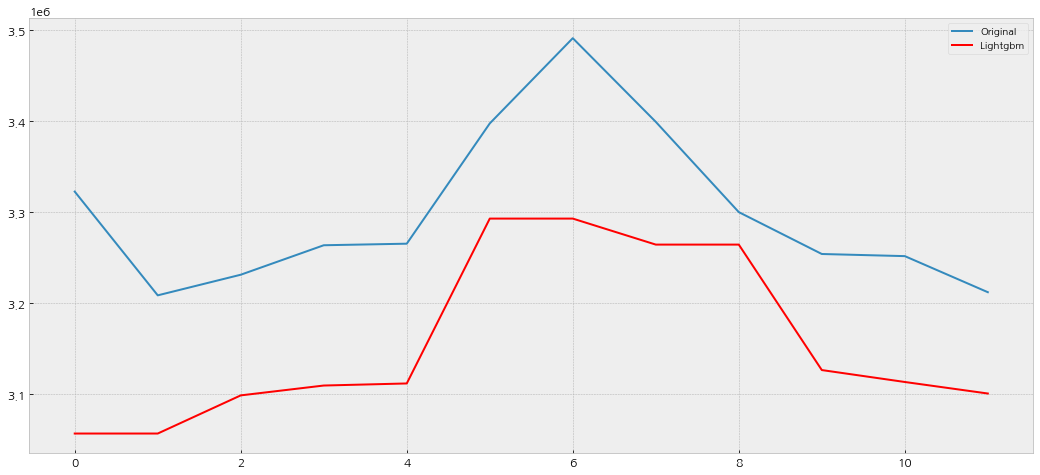

In [37]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm')
plt.legend()

In [38]:
resultsDict

{'Randomforest': {'mae': 161667.80997866264,
  'rmse': 174049.61361410082,
  'mape': 0.04926643657162172,
  'r2': -3.3239051020151953},
 'XGBoost': {'mae': 230847.10549155145,
  'rmse': 245095.27352586162,
  'mape': 0.07034601528040747,
  'r2': -7.574324180173743},
 'Lightgbm': {'mae': 142274.23472600838,
  'rmse': 151585.1002472247,
  'mape': 0.0430572897578542,
  'r2': -2.2797674951532616}}

In [39]:
X_predict_df, y_predict = create_time_features(
    total_data_df.loc["2022-01-01":], target=CITY_NAME)
scaler = StandardScaler()
scaler.fit(X_predict_df)  # No cheating, never scale on the training+test!
X_predit = scaler.transform(X_predict_df)

water_predict = lightGBM.predict(X_predit)

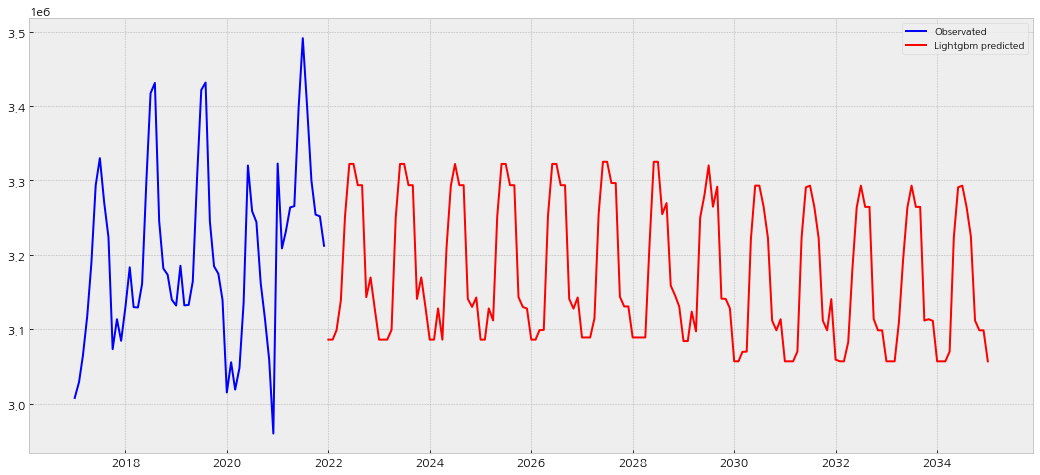

In [40]:
total_data_df[CITY_NAME].loc["2022-01-01":] = water_predict
plt.plot(total_data_df[CITY_NAME].loc[:"2021-12-01"], color='blue', label='Observated')
plt.plot(total_data_df[CITY_NAME].loc["2022-01-01":], color='red', label='Lightgbm predicted')
plt.legend()

### 4.4 Prophet multivariate

In [42]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={CITY_NAME: 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={CITY_NAME: 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [43]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    #daily_seasonality=True,
)#.add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [44]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

08:03:20 - cmdstanpy - INFO - Chain [1] start processing
08:03:21 - cmdstanpy - INFO - Chain [1] done processing


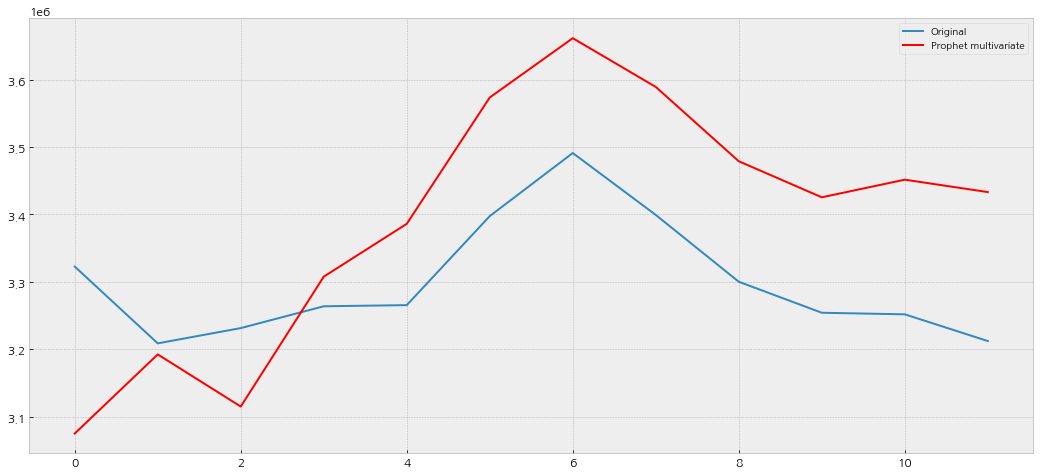

In [45]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

In [46]:
resultsDict

{'Randomforest': {'mae': 161667.80997866264,
  'rmse': 174049.61361410082,
  'mape': 0.04926643657162172,
  'r2': -3.3239051020151953},
 'XGBoost': {'mae': 230847.10549155145,
  'rmse': 245095.27352586162,
  'mape': 0.07034601528040747,
  'r2': -7.574324180173743},
 'Lightgbm': {'mae': 142274.23472600838,
  'rmse': 151585.1002472247,
  'mape': 0.0430572897578542,
  'r2': -2.2797674951532616},
 'Prophet multivariate': {'mae': 154322.9311631374,
  'rmse': 167747.5876702336,
  'mape': 0.04662617243261025,
  'r2': -3.0164521156406137}}

In [47]:
# Prophet needs some specifics data stuff, coment it here
prophet_predict = total_data_df.loc["2022-01-01":].rename(columns={CITY_NAME: 'y'})  # old method
prophet_predict['ds'] = prophet_predict.index
prophet_predict.index = pd.RangeIndex(len(prophet_predict.index))

In [54]:
prophet_predict['date'] = prophet_predict["ds"]
prophet_predict['month'] = prophet_predict['date'].dt.month
prophet_predict['year'] = prophet_predict['date'].dt.year

In [55]:
water_predict = prophet.predict(prophet_predict)

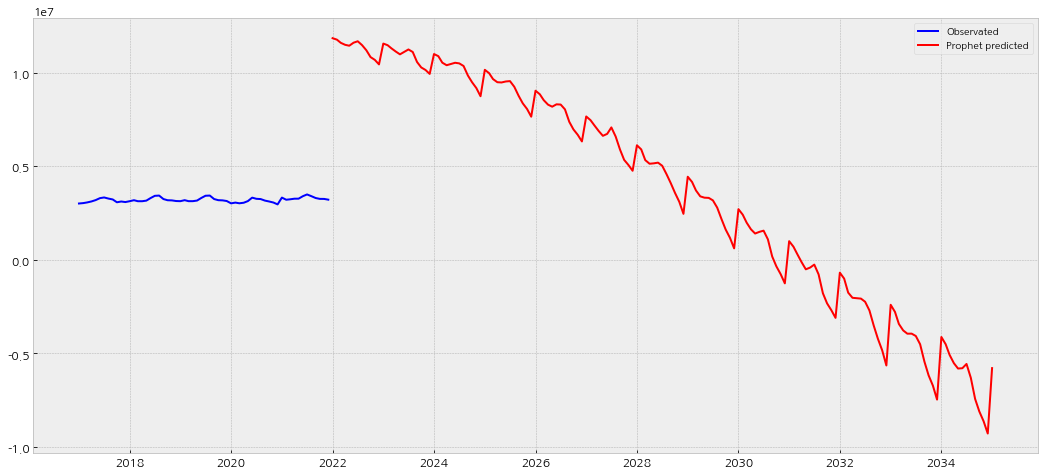

In [56]:
total_data_df[CITY_NAME].loc["2022-01-01":] = water_predict.yhat.values
plt.plot(total_data_df[CITY_NAME].loc[:"2021-12-01"], color='blue', label='Observated')
plt.plot(total_data_df[CITY_NAME].loc["2022-01-01":], color='red', label='Prophet predicted')
plt.legend()

### 4.5 DeepAR

[DeepAR](https://arxiv.org/pdf/1704.04110.pdf) is a deep learning architecture released by amazon

In [57]:
features = df_training.columns[1:11]

scaler = StandardScaler()
scaler.fit(X_train[:,:10])  # No cheating, never scale on the training+test!
df_training[features] = scaler.transform(df_training[features])
df_test[features] = scaler.transform(df_test[features])


training_data = ListDataset(
    [{"start": df_training.index[0], "target": df_training[CITY_NAME],
      'feat_dynamic_real': [df_training[feature] for feature in features]
      }],
    freq="d"
)
test_data = ListDataset(
    [{"start": df_test.index[0], "target": df_test[CITY_NAME],
      'feat_dynamic_real': [df_test[feature] for feature in features]
      }],
    freq="d"
)

In [58]:
estimator = DeepAREstimator(freq="d",
                            prediction_length=1, context_length=30,
                            trainer=Trainer(epochs=5))

predictor = estimator.train(training_data=training_data)


forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_test))

forecasts = list(forecast_it)
tss = list(ts_it)


100%|██████████| 50/50 [00:24<00:00,  2.02it/s, epoch=5/5, avg_epoch_loss=12.5]


In [59]:
yhat = forecasts[0].samples.reshape(1, -1)[0]
resultsDict['DeepAR'] = evaluate(y_test, yhat)
predictionsDict['DeepAR'] = yhat

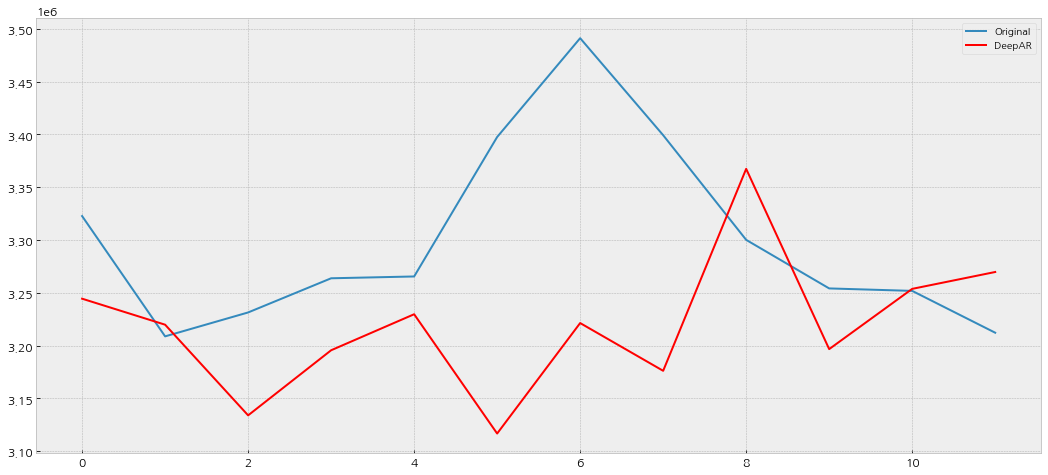

In [60]:
plt.plot(df_test[CITY_NAME].values, label='Original')
plt.plot(yhat, color='red', label='DeepAR')
plt.legend()

In [61]:
resultsDict

{'Randomforest': {'mae': 161667.80997866264,
  'rmse': 174049.61361410082,
  'mape': 0.04926643657162172,
  'r2': -3.3239051020151953},
 'XGBoost': {'mae': 230847.10549155145,
  'rmse': 245095.27352586162,
  'mape': 0.07034601528040747,
  'r2': -7.574324180173743},
 'Lightgbm': {'mae': 142274.23472600838,
  'rmse': 151585.1002472247,
  'mape': 0.0430572897578542,
  'r2': -2.2797674951532616},
 'Prophet multivariate': {'mae': 154322.9311631374,
  'rmse': 167747.5876702336,
  'mape': 0.04662617243261025,
  'r2': -3.0164521156406137},
 'DeepAR': {'mae': 104038.5174923195,
  'rmse': 139700.85770966066,
  'mape': 0.030922432803237462,
  'r2': -1.7856604089728565}}

In [62]:
df_deepar = total_data_df.loc["2022-01-01":]
df_deepar.head()

,서울특별시,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,고령화비율,기온,월강수량,습도
date,,,,,,,,,,,
2022-01-01,1.183407e+07,9487764.0,3873473.0,2.44942,4591453.0,4896311.0,0.937737,0.170804,-0.948870,32.493489,0.600252
2022-02-01,1.175603e+07,9487764.0,3873473.0,2.44942,4591453.0,4896311.0,0.937737,0.170804,2.762175,0.000306,0.512353
2022-03-01,1.158582e+07,9487764.0,3873473.0,2.44942,4591453.0,4896311.0,0.937737,0.170804,6.777495,60.479186,0.573968
2022-04-01,1.148063e+07,9487764.0,3873473.0,2.44942,4591453.0,4896311.0,0.937737,0.170804,14.580462,98.223170,0.582993
2022-05-01,1.143159e+07,9487764.0,3873473.0,2.44942,4591453.0,4896311.0,0.937737,0.170804,20.175607,135.633470,0.708381


In [69]:
features = df_training.columns[1:11]

scaler = StandardScaler()
scaler.fit(X_train[:,:10])  # No cheating, never scale on the training+test!
df_deepar[features] = scaler.transform(df_deepar[features])

test_data = ListDataset(
    [{"start": df_deepar.index[0], "target": df_deepar[CITY_NAME],
      'feat_dynamic_real': [df_deepar[feature] for feature in features]
      }],
    freq="m"
)

In [70]:
forecast_it, ts_it = make_evaluation_predictions(
    test_data, predictor=predictor, num_samples=len(df_deepar))

forecasts = list(forecast_it)
tss = list(ts_it)

In [71]:
yhat = forecasts[0].samples.reshape(1, -1)[0]

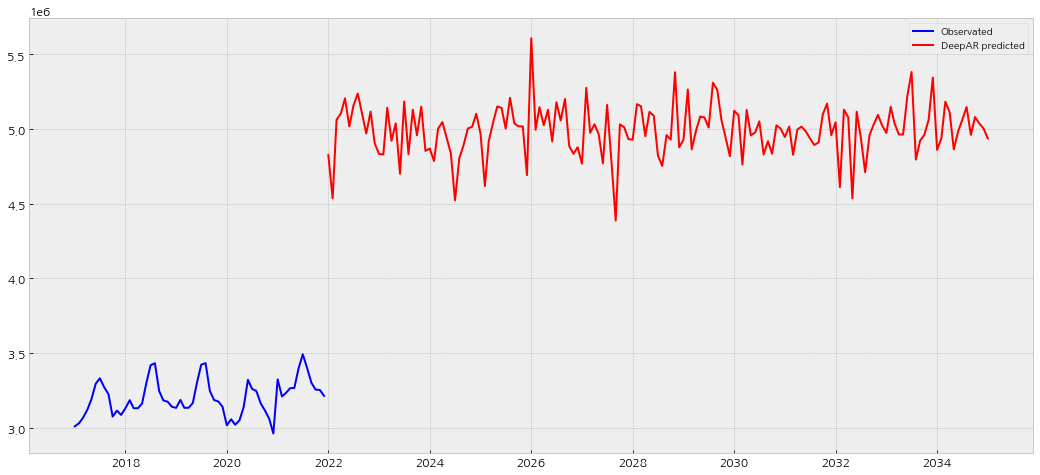

In [72]:
total_data_df[CITY_NAME].loc["2022-01-01":] = yhat
plt.plot(total_data_df[CITY_NAME].loc[:"2021-12-01"], color='blue', label='Observated')
plt.plot(total_data_df[CITY_NAME].loc["2022-01-01":], color='red', label='DeepAR predicted')
plt.legend()